### Imports

In [42]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from huggingface_hub import from_pretrained_keras

### Constants

In [20]:
LATENT_DIMS = 64
DENSE_NEURONS = 256
BATCH_SIZE = 16
EPOCHS = 500
denoise_model = from_pretrained_keras("google/maxim-s3-denoising-sidd")

config.json not found in HuggingFace Hub.


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

(…)bc55ec1a669f85307a560a1b045fb9/README.md:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

C:\Users\RMagowan\.virtualenvs\flaig-nWd6_gjl\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\RMagowan\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(…)02bc55ec1a669f85307a560a1b045fb9/LICENSE:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

(…)c1a669f85307a560a1b045fb9/.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/6.64M [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/170k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/72.3M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

### Functions

In [80]:
def img_from_np(image, shape=(96, 96, 3)):
    return Image.fromarray(np.uint8(image.reshape(shape)*255))

def denoise_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (256, 256))
    denoised = denoise_model.predict(image, verbose=0)

    return denoised

def show_reconstructions(images, n=10, denoise=True):
    plt.figure(figsize=(int(n/2), n*2))
    random_idx = np.random.choice(images.shape[0], size=n, replace=False)
    sample_imgs = images[random_idx]
    i = 0

    for image in tqdm(sample_imgs):
        # Get original image
        orig = img_from_np(image)
        
        # Encode image
        rep = np.array(encoder.predict(np.array([image]), verbose=0))

        # Decode image
        recons = []
        for r in rep:
            recons.append(decoder.predict(r, verbose=0))
        recon = (recons[0] + recons[1] + recons[2]) / 3
        recon_img = img_from_np(recon)

        # Denoise image
        if denoise:
            a = denoise_image(recon)
            recon_img = img_from_np(a[2][1].reshape((128, 128, 3)), shape=(128, 128, 3))

        # Plot
        plt.subplot(n+ 1, 2, i + 1)
        plt.imshow(orig)
        plt.subplot(n + 1, 2, i + 2)
        plt.imshow(recon_img)
        i = i+2

### Sampling Layer

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [5]:
latent_dim = LATENT_DIMS

encoder_inputs = keras.Input(shape=(96, 96, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(DENSE_NEURONS, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 24, 24, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 36864)                0         ['conv2d_1[0][0]']            
                                                                                            

### Decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(36864, activation="relu")(latent_inputs)
x = layers.Reshape((24, 24, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 36864)             2396160   
                                                                 
 reshape (Reshape)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 48, 48, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 96, 96, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 96, 96, 3)         867 

### VAE

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Load Data

In [8]:
image_paths = glob("training_data/*.png")
images = np.array([np.array(Image.open(path)) for path in image_paths])
images = images.astype("float32") / 255
images.shape

(249, 96, 96, 3)

### Train

In [14]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(images, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback])

Epoch 1/500
16/16 [==============================] - 8s 408ms/step - loss: 4561.6446 - reconstruction_loss: 4473.6421 - kl_loss: 29.3757
Epoch 2/500
16/16 [==============================] - 6s 379ms/step - loss: 4458.6827 - reconstruction_loss: 4444.8359 - kl_loss: 26.4053
Epoch 3/500
16/16 [==============================] - 6s 374ms/step - loss: 4429.1762 - reconstruction_loss: 4428.5132 - kl_loss: 29.2331
Epoch 4/500
16/16 [==============================] - 6s 394ms/step - loss: 4424.4109 - reconstruction_loss: 4352.6992 - kl_loss: 37.9104
Epoch 5/500
16/16 [==============================] - 6s 388ms/step - loss: 4374.7548 - reconstruction_loss: 4280.6904 - kl_loss: 43.3850
Epoch 6/500
16/16 [==============================] - 6s 363ms/step - loss: 4315.7313 - reconstruction_loss: 4235.1240 - kl_loss: 39.1603
Epoch 7/500
16/16 [==============================] - 5s 348ms/step - loss: 4210.9873 - reconstruction_loss: 4155.5664 - kl_loss: 47.0922
Epoch 8/500
16/16 [======================

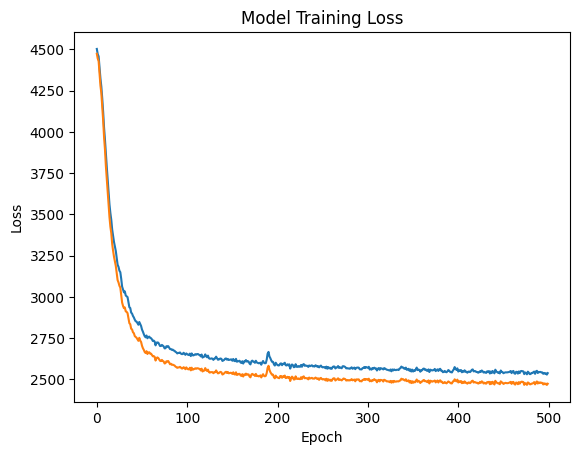

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['reconstruction_loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Reconstruct

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]


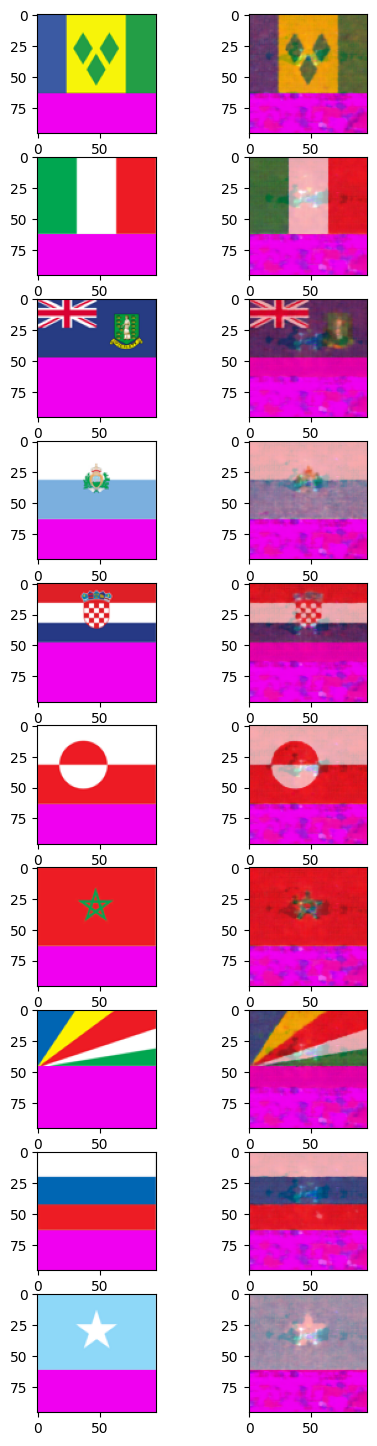

In [82]:
show_reconstructions(images, denoise=False)

### Generate

1/1 [==============================] - 0s 32ms/step


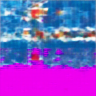

In [95]:
img_from_np(decoder.predict(np.array([np.array([0.9] * 64)])))